# HW 1 
## Homework 1 for SOCS course 
### Viggo Wessner 

#### **Exercise 1. Brownian disk with Lennard Jones potential**
Simulate a Brownian disk (see Fig. 1.8 in the book). Start with a single disk (radius Rdisk, mass mdisk) and
N 2
part particles (point-like, mass m). The particles do not mutually interact. The interaction happens only
among the disk and the particles through a Lennard-Jones potential (parameters: σ = 1, $\epsilon$ = 1).
The system is enclosed in a squared box with reflecting boundaries. The size of the box is L × L. Initially, the
particles are positioned on a squared lattice. They have a velocity with random orientation and magnitude v.
The disk start from the center of the box from rest (i.e., its velocity is 0). In the simulation, use the following
parameters:
##### **P1** - trajectory of the disk in the Cartesian plane.



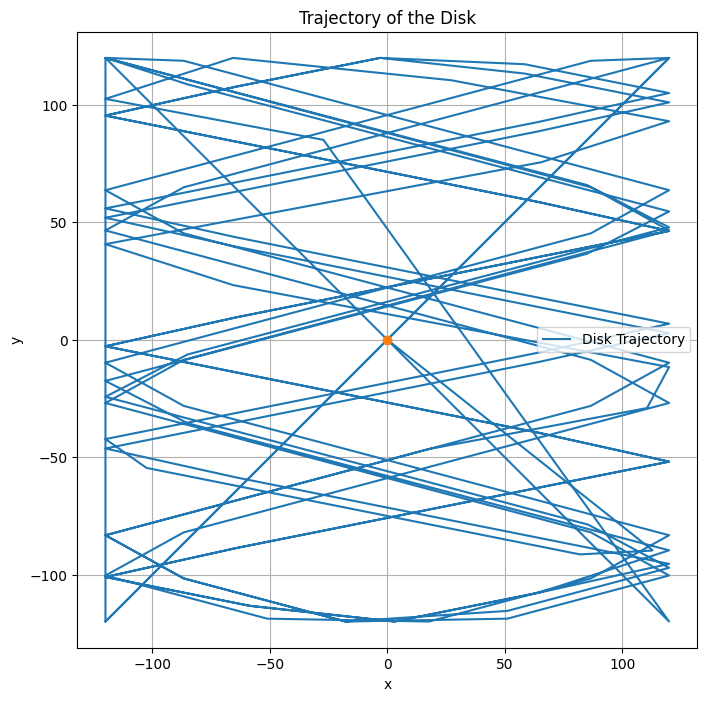

In [4]:
import numpy as np
import matplotlib.pyplot as plt

sigma = 1
eps = 1


m_p = 1
v0_p = 10
N_p = 25

m_d = 10
R_d = 10
vx_d = 0
vy_d = 0
L = 260

T = 400
dt = 0.005

x_d = 0
y_d = 0

x_min, x_max, y_min, y_max = -L/2, L/2, -L/2, L/2





# Generate initial positions on a grid and orientations at random.
x0, y0 = np.meshgrid(
    np.linspace(- L / 2, L / 2, int(np.sqrt(N_p))),
    np.linspace(- L / 2, L / 2, int(np.sqrt(N_p))),
)
x0 = x0.flatten()[:N_p]
y0 = y0.flatten()[:N_p]
phi0 = (2 * np.random.rand(N_p) - 1) * np.pi


# Filter out particles within 3σ of disk rim
filtered_indices = []
for i in range(N_p):
    r = np.sqrt((x_d - x0[i])**2 + (y_d - y0[i])**2)
    if r >= R_d + 3 * sigma:
        filtered_indices.append(i)

# Initialize the variables for the leapfrog algorithm.
# Current time srep.
N_p = len(filtered_indices)

x = x0[filtered_indices]
y = y0[filtered_indices]
x_half = np.zeros(N_p)
y_half = np.zeros(N_p)
v = v0_p
phi = phi0[filtered_indices]
vx = v0_p * np.cos(phi)
vy = v0_p* np.sin(phi)

# Next time step.
nx = np.zeros(N_p)
ny = np.zeros(N_p)
nv = np.zeros(N_p)
nphi = np.zeros(N_p)
nvx = np.zeros(N_p)
nvy = np.zeros(N_p)




def lennard_jones_force(r):
    """Calculate Lennard-Jones force."""
    if r <= 0:
        return 0
    return 24 * (eps/r) * ((2 * (sigma / r)**12) - ((sigma / r)**6)) 



def total_force(x,y, N_p):
    """
    Calculate the total Lennard-Jones force on the disk from all particles.

    Returns:
        Fx: Total force in x-direction on the disk
        Fy: Total force in y-direction on the disk
        Fx_p: Array of forces in x-direction on each particle
        Fy_p: Array of forces in y-direction on each particle
    """
    Fx = 0
    Fy = 0
    Fx_p = np.zeros(N_p)
    Fy_p = np.zeros(N_p)

    for i in range(N_p):
        dx = x_d - x[i]
        dy = y_d - y[i]
        distance = np.sqrt(dx**2 + dy**2)
        r = distance - R_d
        if r > 0:
            F = lennard_jones_force(r)
            Fx_component = F * (dx) / distance
            Fy_component = F * (dy) / distance
            Fx += Fx_component
            Fy += Fy_component
            Fx_p[i] += Fx_component
            Fy_p[i] += Fy_component

    return Fx, Fy, Fx_p, Fy_p




disc_positions = []
num_steps = int(T / dt)
for step in range(num_steps):
    x_half = x + 0.5*vx*dt
    y_half = y + 0.5*vy*dt

    fx, fy, fx_p, fy_p = total_force(x_half, y_half, N_p)
#Disc stuff
    nvx_d = vx_d + (fx/m_d) * dt
    nvy_d = vy_d + (fy/m_d) * dt

    nx_d = x_d + vx_d
    ny_d = y_d + vy_d

#Particle stuff

    nvx = vx + fx / m_p * dt
    nvy = vy + fy / m_p * dt

    nx = x_half + 0.5 * nvx * dt
    ny = y_half + 0.5 * nvy * dt


    
    #Reflect boundary conditions for particles and check if touch disc
    for j in range(N_p):
        if nx[j] < x_min:
            nx[j] = x_min + (x_min - nx[j])
            nvx[j] = - nvx[j]

        if nx[j] > x_max:
            nx[j] = x_max - (nx[j] - x_max)
            nvx[j] = - nvx[j]

        if ny[j] < y_min:
            ny[j] = y_min + (y_min - ny[j])
            nvy[j] = - nvy[j]
            
        if ny[j] > y_max:
            ny[j] = y_max - (ny[j] - y_max)
            nvy[j] = - nvy[j]
        if (np.sqrt( (x_d - nx[j])**2 + (y_d - ny[j])**2 ) < R_d):
            nvx[j] = - nvx[j]
            nvy[j] = - nvy[j]

    # Reflect disc at boundaries
        if (nx_d - R_d < x_min) or (nx_d + R_d > x_max):
            nvx_d = -nvx_d
        # Adjust position to lie within boundaries
            if nx_d - R_d < x_min:
                nx_d = x_min + R_d
            elif nx_d + R_d > x_max:
                nx_d = x_max - R_d

        if (ny_d - R_d < y_min) or (ny_d + R_d > y_max):
            nvy_d = -nvy_d
        # Adjust position to lie within boundaries
            if ny_d - R_d < y_min:
                ny_d = y_min + R_d
            elif ny_d + R_d > y_max:
                ny_d = y_max - R_d


    #Store disc pos
    disc_positions.append((x_d, y_d))

    # Update variables for next iteration
    x = nx.copy()
    y = ny.copy()
    vx = nvx.copy()
    vy = nvy.copy()
    x_d = nx_d
    y_d = ny_d
    vx_d = nvx_d
    vy_d = nvy_d

disc_positions = np.array(disc_positions)

# Plot P1: Trajectory of the disk
plt.figure(figsize=(8, 8))
plt.plot(disc_positions[:, 0], disc_positions[:, 1], label="Disk Trajectory")
plt.plot(disc_positions[0,0], disc_positions[0,1], "-o")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Trajectory of the Disk")
plt.legend()
plt.grid(True)
plt.axis('equal')  # Ensure equal scaling on both axes
plt.show()


##### **P2** - plot MSD as a function of time $t=n\Delta t$, calculated as: $$MSD(n\Delta t) =\frac{1}{N-n}\sum_{i=1}^{N-n}(X_{i+n}- X_i)^2 + (Y_{i+n} - Y_i)^2$$

In [11]:
def MSD(disc_positions, dt, time_steps):
    msd = np.zeros(time_steps)
    for n in range(time_steps):
        N = time_steps
        sumTot = 0
        for i in range(1, N-n):
            sumTot += (disc_positions[i+n,0] - disc_positions[i,0])**2 + (disc_positions[i+n,1] - disc_positions[i,1])**2
        msd[n] += sumTot / (N-n)

    return msd



msd_values = MSD(disc_positions, dt, num_steps)
msd_times = np.arange(1, len(msd_values) + 1) * dt


plt.figure(figsize=(8, 6))
plt.plot(msd_times, msd_values, label='MSD', color='blue')
plt.xlabel('Time (t = n * Δt)')
plt.ylabel('Mean Squared Displacement (MSD)')
plt.title('Mean Squared Displacement vs Time')
plt.legend()
plt.grid()
plt.show()

        

KeyboardInterrupt: 